# FIDS: Federated Intrusion Detection System


---


This notebook contains code for both training and evaluating a federated autoencoder-based anomaly detector for the SynCAN dataset.

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import output

Mounted at /content/drive


In [2]:
# #install python 3.9
# !sudo apt-get update -y
# !sudo apt-get install python3.9

# #change alternatives
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

# #check python version
# !python --version
# # returns Python 3.9.13


In [3]:
# install dependencies for TensorFlow Federated and asyncio
# tensorflow federated 0.20.0 is the last version which supports python 3.7 (the native python version in colab)
# tensorflow probability 0.16.0 is currently needed for compatibility reasons
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet tensorflow-probability==0.16.0
output.clear()

In [4]:
!pip install -q tqdm>=4.36.1

In [5]:
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'GPU: {gpu_info[599:619]}')
ram_gb = virtual_memory().total / 1e9
print(f'RAM: {ram_gb:.1f} GB')

GPU: NVIDIA A100-SXM...  
RAM: 89.6 GB


In [6]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()

In [7]:
signal_counts = [2, 3, 2, 1, 2, 2, 2, 1, 1, 4] # number of signals contained in each message ID

In [8]:
NUM_CLIENTS = 3
ID = 5
MSG_ID = 'id'+str(ID)      # each message contains 1-4 signals that are associated with the specified message ID
NUM_SIGNALS = signal_counts[ID-1]
TRAIN_SPLIT = 0.8
TIME_STEPS = 100
SEQ_STRIDE = TIME_STEPS // 2 # must be <= TIME_STEPS
EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROP_OUT = True
LOSS_FUNCTION = 'mse'
METRIC = 'binary_crossentropy'
PATIENCE = 1
LATENT_DIM = 32 * NUM_SIGNALS
DIRECTORY = "/content/drive/MyDrive/Colab Notebooks/models/fids/"
FILEPATH = DIRECTORY+MSG_ID+"_model_"+str(TIME_STEPS)+".h5"
EVAL_SET = 'continuous'
# PNGFILEPATH = DIRECTORY+MSG_ID+"_model.png"

# Preparing the SynCAN Dataset

In [9]:
# Download SynCAN dataset from the ETAS github
!git clone https://github.com/etas/SynCAN.git &> /dev/null
!unzip ./SynCAN/\*.zip -d ./SynCAN/. &> /dev/null
!rm ./SynCAN/*.zip &> /dev/null

In [10]:
def train_csv2df(dir_path): # imports training files into a dataframe
    data_frames = []
    csv_path = dir_path + '/train_1.csv'    # train 1 contains header
    df_temp = pd.read_csv(csv_path)
    data_frames.append(df_temp)
    for i in range(2, 5):
        csv_path = dir_path + '/train_' + str(i) + '.csv'
        df_temp = pd.read_csv(csv_path, header=None, names=['Label',  'Time', 'ID',
                                                            'Signal1', 'Signal2',  'Signal3', 'Signal4'])
        data_frames.append(df_temp)
    df = pd.concat(data_frames)
    return df

def prepare_train_df(): # convert csv, isolate message ID and remove unused columns
    df = train_csv2df('/content/SynCAN')
    print(f'{len(df):,} total messages (id1,id2,...,id10)')

    df = df[:][df.ID==MSG_ID] # use only messages with MSG_ID
    df = df.dropna(axis=1, how='all') # remove unused signal columns
    df.reset_index(drop=True, inplace=True)

    df_labels = df.iloc[:,0:1].astype(int) # dataframe of labels (removing Time and ID columns)
    df = df.iloc[:,3:] # dataframe of signal values
    df = df_labels.join(df)
    print(f'{len(df):,} messages used ({MSG_ID})\n')
    return df

In [11]:
df = prepare_train_df()
df

29,669,726 total messages (id1,id2,...,id10)
4,139,820 messages used (id5)



,Label,Signal1,Signal2
0,0,0.000000,0.958686
1,0,0.000000,0.958686
2,0,0.000000,0.958686
3,0,0.000000,0.956420
4,0,0.000000,0.956420
...,...,...,...
4139815,0,0.329627,0.948088
4139816,0,0.334278,0.948088
4139817,0,0.338807,0.948088
4139818,0,0.342955,0.948461


Viewing messages 3680612 to 3681612



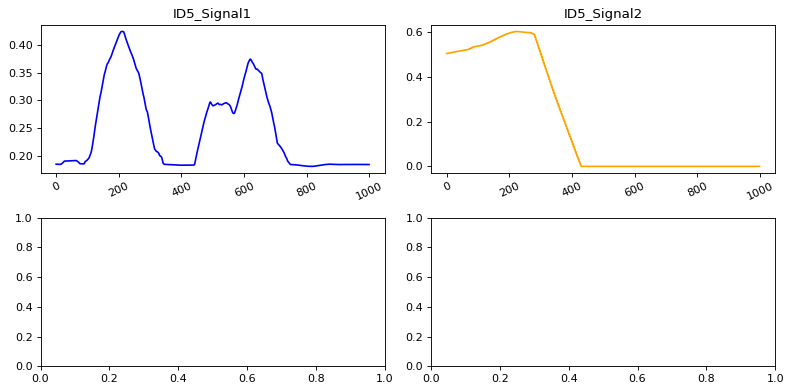

In [12]:
def visualize_data(df, length=1000, start=0):
    data = df.iloc[start:start+length].copy()
    colors = ['blue', 'orange', 'green', 'red']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
    for i in range(df.shape[1]-1):
        key = 'Signal'+str(i+1)
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = list(range(length))
        ax = t_data.plot(
            ax = axes[i // 2, i % 2],
            color = c,
            title = MSG_ID.upper()+'_'+key,
            rot = 25,
        )
    plt.tight_layout()
    plt.show()

length = 1000
start = np.random.randint(len(df)-length)
print(f'Viewing messages {start} to {start+length}\n')
visualize_data(df, start=start, length=length)

In [13]:
# derived from the keras timeseries_dataset_from_array function
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array
def timeseries_dataset(
    data,
    targets,
    sequence_length,
    data_is_target=False,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=1,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None):
  
  if start_index is None:
    start_index = 0
  if end_index is None:
    end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory usage).
  num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
  if targets is not None:
    num_seqs = min(num_seqs, len(targets))
  if num_seqs < 2147483647:
    index_dtype = 'int32'
  else:
    index_dtype = 'int64'

  # Generate start positions
  start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
  if shuffle:
    if seed is None:
      seed = np.random.randint(1e6)
    rng = np.random.RandomState(seed)
    rng.shuffle(start_positions)

  sequence_length = tf.cast(sequence_length, dtype=index_dtype)
  sampling_rate = tf.cast(sampling_rate, dtype=index_dtype)

  positions_ds = tf.data.Dataset.from_tensors(start_positions).repeat()

  # For each initial window position, generates indices of the window elements
  indices = tf.data.Dataset.zip(
      (tf.data.Dataset.range(len(start_positions)), positions_ds)).map(
          lambda i, positions: tf.range(  # pylint: disable=g-long-lambda
              positions[i],
              positions[i] + sequence_length * sampling_rate,
              sampling_rate),
          num_parallel_calls=tf.data.AUTOTUNE)

  dataset = sequences_from_indices(data, indices, start_index, end_index)
  if targets is not None:
    indices = tf.data.Dataset.zip(
        (tf.data.Dataset.range(len(start_positions)), positions_ds)).map(
            lambda i, positions: positions[i],
            num_parallel_calls=tf.data.AUTOTUNE)
    target_ds = sequences_from_indices(
        targets, indices, start_index, end_index)
    dataset = tf.data.Dataset.zip((dataset, target_ds))
  else:
    if data_is_target:
        dataset = tf.data.Dataset.zip((dataset, dataset))
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  if batch_size is not None:
    if shuffle:
      # Shuffle locally at each iteration
      dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
  else:
    if shuffle:
      dataset = dataset.shuffle(buffer_size=1024, seed=seed)
  return dataset

def sequences_from_indices(array, indices_ds, start_index, end_index):
  dataset = tf.data.Dataset.from_tensors(array[start_index : end_index])
  dataset = tf.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
      lambda steps, inds: tf.gather(steps, inds),  # pylint: disable=unnecessary-lambda
      num_parallel_calls=tf.data.AUTOTUNE)
  return dataset


In [14]:
# Define training, validation and testing datasets using the training dataset function
def SynCAN_train_ds(df):
    values = df.to_numpy()[:,1:]
    ds = timeseries_dataset(
        values,
        None,
        data_is_target = True,
        sequence_length = TIME_STEPS,
        sequence_stride = SEQ_STRIDE,
        # batch_size = BATCH_SIZE
    )
    return ds

client_dataframes = np.array_split(df, NUM_CLIENTS)
client_datasets = []
for client_df in client_dataframes:
    data_length = len(client_df)
    train_size = (int(data_length*TRAIN_SPLIT) // SEQ_STRIDE) * SEQ_STRIDE
    test_size = ((data_length - train_size) // SEQ_STRIDE) * SEQ_STRIDE
    train_df = client_df.iloc[:train_size]
    test_df = client_df.iloc[-test_size:]
    train_ds = SynCAN_train_ds(train_df)
    test_ds = SynCAN_train_ds(test_df)
    client_datasets.append({'train': train_ds, 'test': test_ds})

for i, client_dict in enumerate(client_datasets):
    print(f'CLIENT {i}:')
    for key, item in client_dict.items():
        print(f"{key.upper()}: \t{item.__len__().numpy():,} subsequences of length {TIME_STEPS}")
    print()

CLIENT 0:
TRAIN: 	22,078 subsequences of length 100
TEST: 	5,518 subsequences of length 100

CLIENT 1:
TRAIN: 	22,078 subsequences of length 100
TEST: 	5,518 subsequences of length 100

CLIENT 2:
TRAIN: 	22,078 subsequences of length 100
TEST: 	5,518 subsequences of length 100



# Defining a TensorFlow Federated Model

In [15]:
def get_FIDS_model(time_steps, input_dim, latent_dim, drop_out=False):
    inputs = layers.Input(shape=(time_steps, input_dim)) # shape = (time_steps, data_dimension/num_features)
    # encoder
    x = layers.Dense(latent_dim*2, activation='tanh')(inputs)
    if drop_out: x = layers.Dropout(0.2)(x)
    enc_out, enc_hidden = layers.GRU(latent_dim, return_sequences=True, return_state=True, activation="tanh")(x)
    if drop_out:
        enc_out = layers.Dropout(0.2)(enc_out)
        enc_hidden = layers.Dropout(0.2)(enc_hidden)
    # decoder
    dec_out , dec_hidden = layers.GRU(latent_dim, return_sequences=True, return_state=True, activation="tanh")(enc_out)
    if drop_out:
        dec_out = layers.Dropout(0.2)(dec_out)
        dec_hidden = layers.Dropout(0.2)(dec_hidden)
    
    outputs = layers.Dense(input_dim, activation='tanh')(dec_out)
    model = tf.keras.Model(inputs, outputs)
    return model

def model_fn():
    model = get_FIDS_model(time_steps=TIME_STEPS,
                           input_dim=NUM_SIGNALS,
                           latent_dim=LATENT_DIM,
                           drop_out=DROP_OUT)
    return tff.learning.from_keras_model(
        model,
        input_spec = client_datasets[0]['train'].element_spec,
        loss=tf.keras.losses.MeanSquaredError())

# Model Training, Aggregation and Validation

In [16]:
# create federated learning process and train
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    # server_optimizer_fn=lambda: tf.keras.optimizers.Adam()
)

state = trainer.initialize()
train_datasets = [client_dict['train'] for client_dict in client_datasets] # .batch(BATCH_SIZE) for client_dict in client_datasets]
train_hist = []
for i in range(EPOCHS):
    start_time = time.time()
    state, metrics = trainer.next(state, train_datasets)
    train_hist.append(metrics)
    end_time = time.time()
    time = start_time - end_time
    print(f"\rRun {i+1}/{EPOCHS}")
    print(f"\tTime: {time}")
    print(f"\tLoss: {metrics['train']['loss']}")

Run 1/3
	Time: -15912.665416955948
	Loss: 0.0016683993162587285


AttributeError: ignored

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)
test_datasets = [client_dict['test'] for client_dict in client_datasets]
federated_metrics = evaluator(state.model, test_datasets)
print(f"Loss: {federated_metrics['eval']['loss']}")

In [ ]:
model = get_FIDS_model(time_steps=TIME_STEPS,
                       input_dim=NUM_SIGNALS,
                       latent_dim=LATENT_DIM,
                       drop_out=DROP_OUT)
model.compile(loss=LOSS_FUNCTION, metrics=[METRIC])
model_weights = trainer.get_model_weights(state)
model_weights.assign_weights_to(model)
model.save(FILEPATH)
loss, metric = model.evaluate(client_datasets[0]['test'], steps=2, verbose=0)
print(f'Test loss: {loss:.5f}\nTest {METRIC}: {metric:.6f}')

# Reconstructing Data and Selecting Thresholds

In [ ]:
def reconstruct(ds): # used for reconstructing signals with a saved model into a continuous dataframe
    saved_model = tf.keras.models.load_model(FILEPATH)
    reconstruction = saved_model.predict(ds, verbose=1, workers=-1, use_multiprocessing=True)
    if TIME_STEPS == SEQ_STRIDE:
        reconstruction = reconstruction.reshape(-1, reconstruction.shape[-1])
    else:
        # remove duplicate timesteps from predictions
        # first = reconstruction[0,:TIME_STEPS-SEQ_STRIDE]    # e.g. [0..10] out of [0..20]
        first = reconstruction[0]
        rest = reconstruction[1:,TIME_STEPS-SEQ_STRIDE:]    # e.g. [10..20],[20..30].. out of [10..30],[20..40]..
        rest = rest.reshape(-1, rest.shape[-1])             # e.g. [10....len(df)]
        reconstruction = np.concatenate((first, rest))      # e.g. [0....len(df)]
    columns = ['Signal'+str(i+1) for i in range(reconstruction.shape[-1])]
    return pd.DataFrame(reconstruction, columns=columns)

def get_thresholds(df, reconstruction): # used for detecting reconstructions that are significantly different from the orignal
    # returns a numpy array containing a threshold for each signal
    real_values = df.to_numpy()[:,1:]
    reconstructed_values = reconstruction.to_numpy()
    squared_error = np.square(real_values - reconstructed_values)
    thresholds = squared_error.mean(axis=0) + (2 * squared_error.std(axis=0))
    return thresholds, squared_error

def get_predictions(df, reconstruction): # used to label messages as normal or anomalous
    # accepts two dataframes of the same length containing the same number of signals
    # returns a numpy array of 1s and 0s similar to the labels in df
    real_values = df.to_numpy()[:,1:]
    reconstructed_values = reconstruction.to_numpy()
    squared_error = np.square(real_values - reconstructed_values)
     # if any signal is above respective threshold, prediction is 1 for that timestep
    predictions = 1*(squared_error > thresholds)
    return predictions

def find_ranges(predictions): # used for highlighting in plots
    # accepts a list/vector of 1s and 0s
    # returns a list of range tuples which contain a start and end index
    ranges = []
    i = 0
    while i < len(predictions):
        if predictions[i]:
            start = i
            while True:
                i += 1
                if i >= len(predictions):
                    break
                if not predictions[i]:
                    break
            end = i
            ranges.append((start, end))
        i += 1
    return ranges

def visualize_reconstructed_signal(in_df, out_df, length=None, start=0, predict=False, show_se=False):
    # accepts two dataframes of the same length with the same number of signals - keys must be Signal1, Signal2,...
    if length is None:
        start = 0
        length = len(in_df)
    data = in_df.iloc[start:start+length].copy()
    reconstructed_data = out_df.iloc[start:start+length].copy()
    num_signals = reconstructed_data.shape[1]
    labels = data['Label']
    nrows = 2 if num_signals > 3 else 1
    ncols = num_signals if num_signals < 4 else 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,nrows*4), dpi=80, facecolor="w", edgecolor="k")
    for i in range(num_signals):
        key = 'Signal'+str(i+1)
        t_data = data[key]
        t_data.index = list(range(length))
        t_reconstructed_data = reconstructed_data[key]
        t_reconstructed_data.index = list(range(length))
        ax = axes[i // 2, i % 2] if nrows>1 else axes[i]
        ax0 = t_data.plot(
            ax=ax,
            color="black",
            title=MSG_ID.upper()+'_'+key,
            rot=25,
        )
        ax1 = t_reconstructed_data.plot(
            ax=ax,
            color="red",
            rot=10,
        )
        if show_se: # plot squared error
            se = np.square(t_data - t_reconstructed_data)
            ax2 = ax0.twinx()
            ax2.plot(se, alpha=0.5)
            ax2.set_ylabel('squared error')
        ranges = find_ranges(labels.to_numpy())
        for start, end in ranges:
            ax0.axvspan(start, end, color='grey', alpha=0.3)    # highlight labeled anomalies
        if predict:
            predictions = get_predictions(data, reconstructed_data)
            ranges = find_ranges(predictions[:, i])
            print(ranges)
            for start, end in ranges:
                ax1.axvspan(start, end, color='red', alpha=0.3) # hightlight predicted anomalies
        ax1.legend(['Original Signal', 'Reconstructed Signal'], loc='upper left')
        ax2.legend(['Squared Error'], loc='upper right')
    plt.tight_layout()
    plt.show()

In [ ]:
test_reconstruction = reconstruct(test_ds)
if test_reconstruction.shape[0] == len(test_df):
    print('reconstruction successful')

In [ ]:
visualize_reconstructed_signal(test_df, test_reconstruction, 2000, show_se=True)

In [ ]:
thresholds, squared_error = get_thresholds(test_df, test_reconstruction)
thresholds

In [ ]:
for signal in range(squared_error.shape[-1]): # Plot histograms of squared error values and mean + threshold lines
    se = squared_error[:,signal]
    plt.figure(figsize=(12,3))
    sns.set(font_scale = 1)
    sns.set_style("white")
    plt.xlim([0, 2*thresholds[signal]])
    sns.histplot(np.clip(se, 0, 2 * thresholds[signal]), bins=50, kde=True, color='grey')
    plt.axvline(x=np.mean(se), color='g', linestyle='--', linewidth=3)
    plt.text(np.mean(se), 250, "Mean", horizontalalignment='left', 
            size='small', color='black', weight='semibold')
    plt.axvline(x=thresholds[signal], color='b', linestyle='--', linewidth=3)
    plt.text(thresholds[signal], 250, "Threshold", horizontalalignment='left', 
            size='small', color='Blue', weight='semibold')
    plt.xlabel('Squared Error')
    plt.title('Signal '+str(signal+1))
    sns.despine()

# Intrusion Detection Evaluation

In [ ]:
def eval_csv2df(dir_path, test_file):  # imports evaluation (abnormal) data into dataframe
    data_frames = []
    csv_path = dir_path + '/test_' + test_file + '.csv'
    df = pd.read_csv(csv_path, header=None, skiprows=1, names=['Label',  'Time', 'ID',
                                                               'Signal1',  'Signal2',  'Signal3',  'Signal4'])
    return df

def prepare_eval_df(test_file='normal'):
    # convert csv, standardize features and trim to multiple of TIME_STEPS
    df = eval_csv2df('/content/SynCAN', test_file)
    print(f'{len(df):,} total messages (id1,id2,...,id10)')
    df = df[:][df.ID==MSG_ID] # use only messages with MSG_ID
    df = df.dropna(axis=1, how='all') # remove unused signal columns
    num_subsequences = len(df) // TIME_STEPS
    df = df.iloc[:(num_subsequences*TIME_STEPS)]
    df.reset_index(drop=True, inplace=True)
    df_labels = df.iloc[:,0:1].astype(int) # dataframe of labels (removing Time and ID columns)
    df = df.iloc[:,3:] # dataframe of signal values
    # df = (df - df.min()) / (df.max() - df.min())  # data seems to be already normalized
    print(f'{len(df):,} messages used ({MSG_ID})')
    num_anomalous = len(df_labels[df_labels['Label']==1])
    print(f'{num_anomalous:,} anomalous messages out of {len(df):,}\n')
    return df_labels.join(df)

def SynCAN_eval_ds(df):
    values = df.to_numpy()[:,1:]
    ds = timeseries_dataset(
        values,
        None,
        data_is_target = False,
        sequence_length = TIME_STEPS,
        sequence_stride = SEQ_STRIDE,
        batch_size = 1,
    )
    return ds

## Evaluation using Normal Data

In [ ]:
normal_df = prepare_eval_df()
normal_ds = SynCAN_eval_ds(normal_df)
# normal_df = normal_df.iloc[:-10]

normal_df.head()

In [ ]:
# produce reconstructed signals
normal_reconstruction = reconstruct(normal_ds)
normal_reconstruction.shape

In [ ]:
predictions = get_predictions(normal_df, normal_reconstruction)
false_positive_rate = len(predictions[predictions==1])/len(predictions)
false_positive_rate

In [ ]:
visualize_reconstructed_signal(normal_df, normal_reconstruction, 2000, start=250, show_se=True)

## Evaluation using Anomalous Data

In [ ]:
eval_df = prepare_eval_df(EVAL_SET)
eval_ds = SynCAN_eval_ds(eval_df)

eval_df.head()

In [ ]:
eval_reconstruction = reconstruct(eval_ds)

In [ ]:
visualize_reconstructed_signal(eval_df, eval_reconstruction, 1500, 2000, predict=True, show_se=True)

In [ ]:
real_labels = eval_df['Label'].to_numpy()
predictions = np.max(get_predictions(eval_df, eval_reconstruction), axis=1)
cm = confusion_matrix(real_labels, predictions)
cm
# True Neg, False Neg
# False Pos, True Pos

In [ ]:
b_accuracy = balanced_accuracy_score(real_labels, predictions)
print(f'Balanced Accuracy: {b_accuracy}')       # current best: 0.523